META_CLASSIFIER 
with complex wavelet transform for time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

'''[0,1] rescaling (max(X))!=0'''
def Norm01(x):
    mi=np.nanmin(x)
    ma=np.nanmax(np.array(x)-mi)
    if ma>0.:
        x_n=(np.array(x)-mi)/ma
        return x_n, mi, ma
    else:
        return np.zeros(len(x)), mi, ma

In [2]:
df=pd.read_csv('artdata_350.csv')
scores=pd.read_csv('res_artdata_RMSE.csv')#('res_real_RMSE.csv')
scores

,level,000,001,002,003,004,005,006,007,008,...,340,341,342,343,344,345,346,347,348,349
0,0,0.003046,0.002471,0.006637,0.004451,0.002409,0.002119,0.002405,0.002999,0.005933,...,0.024352,0.021951,0.035751,0.038672,0.042533,0.011585,0.018256,0.045794,0.044247,0.024264
1,1,0.001663,0.005033,0.002034,0.003121,0.001523,0.001696,0.003282,0.002512,0.002461,...,0.024504,0.019637,0.041683,0.037660,0.042941,0.012899,0.022939,0.046885,0.044902,0.026725
2,2,0.001054,0.002747,0.001366,0.001401,0.002995,0.001004,0.006822,0.003261,0.003468,...,0.023436,0.020347,0.033140,0.040081,0.041182,0.012105,0.019187,0.046799,0.045553,0.024694
3,3,0.001071,0.001392,0.001825,0.002384,0.004208,0.002858,0.002767,0.015949,0.002327,...,0.024559,0.019278,0.038438,0.035122,0.042239,0.011912,0.016702,0.053601,0.045108,0.024122
4,4,0.017383,0.003373,0.001014,0.001203,0.004390,0.004007,0.007293,0.013624,0.002432,...,0.026517,0.021073,0.037337,0.034729,0.044511,0.011174,0.019686,0.047482,0.043663,0.024884


In [3]:
'''Поровну на класс'''
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[1:]#.tolist()
labels.series=allser
a={}
for i in range(5):
    labels['score%i'%i]=scores.loc[i, allser].values
for i in range(5):
    a[i]=labels[labels['score%i'%i].rank(method='dense') <=  (len(df.columns)-1)//5].series.values
    labels=labels.drop(labels[labels['score%i'%i].rank(method='dense') <=  (len(df.columns)-1)//5].index)
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[1:]#.tolist()
labels.series=allser
for i in a.keys():
    labels.loc[labels.series.isin(a[i]), 'level']=i
#labels['l1']=labels.series.astype(int)//70
for i in range(5):
    labels['score%i'%i]=scores.loc[i, allser].values
labels

,series,level,score0,score1,score2,score3,score4
0,000,0,0.003046,0.001663,0.001054,0.001071,0.017383
1,001,0,0.002471,0.005033,0.002747,0.001392,0.003373
2,002,0,0.006637,0.002034,0.001366,0.001825,0.001014
3,003,0,0.004451,0.003121,0.001401,0.002384,0.001203
4,004,0,0.002409,0.001523,0.002995,0.004208,0.004390
...,...,...,...,...,...,...,...
345,345,2,0.011585,0.012899,0.012105,0.011912,0.011174
346,346,3,0.018256,0.022939,0.019187,0.016702,0.019686
347,347,4,0.045794,0.046885,0.046799,0.053601,0.047482
348,348,4,0.044247,0.044902,0.045553,0.045108,0.043663


In [4]:
'''data wavelet transformation'''
import pywt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
def getpicture(time, signal, scales, 
                 waveletname = 'mexh', 
                 cmap = plt.cm.seismic):
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0078125, 0.03125, 0.0625, 0.125, 0.25, 0.5]
    contourlevels = np.log2(levels)
    
    fig = Figure(figsize=(1, 1))
    canvas = FigureCanvasAgg(fig)
    ax = fig.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap='magma')
    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    canvas.draw()
    buf = canvas.buffer_rgba()
    X = np.asarray(buf)[4:-4,5:-3,:3]#/255
    return X

for i in [3]:#set(labels.level.values):
    f=np.random.choice(labels[labels.level==i].series.values)
    print(f)
    x=df[f].values
    x=Norm01(x)[0]
    title=f+' Complexity level %i'%i
    time=np.arange(1,len(x)+1)#pd.date_range(start='2015-01-01', periods=50, freq = 'M')#.strftime('%Y-%m')
    scales = np.arange(1,51)
    #X=plot_wavelet(time, x, scales, title = 'Power Spectrum of '+title)
    x=getpicture(time, x, scales)

321


64

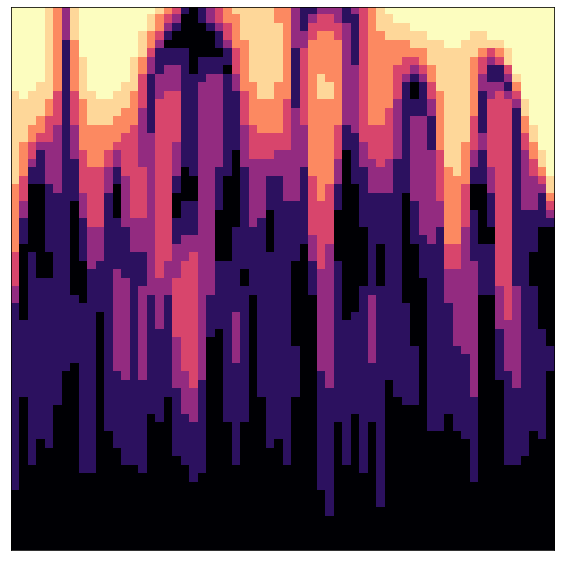

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(x)
plt.xticks([])
plt.yticks([])
s=x.shape[0]
s

In [6]:
''' One-Hot encoding'''
def one_hot(x):
    c=list(set(x))
    c.sort()
    x=np.array(x)
    a=np.zeros((len(x),len(c)))
    for n, j in enumerate(c):
        i=np.where(x==j)[0]
        a[i,n]=1
    return a.astype(int), c

a,c = one_hot(labels['level'].values)
labels[c]=a
time=np.arange(1,500+1)
scales = np.arange(1,51)
X=np.zeros((len(labels), s,s,3))
y=np.zeros((len(labels), len(labels['level'].unique())))
for i,f in enumerate(labels.series[:]):
    data=df[f].values
    data=Norm01(data)[0]
    maxdat=max(data)
    x=getpicture(time, data, scales)
    X[i]=x#/255
    y[i]=labels.loc[i,c]
print('Done')

Done


In [7]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
class_num=y_train.shape[1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_test.max()

((234, 64, 64, 3), (234, 5), (116, 64, 64, 3), (116, 5), 254.0)

In [8]:
try: 
    del model
except:
    print('No model')
else:
    print('Model deleted')

No model


In [9]:
'''Convolutional 2D model'''
seed = 21
dro=.3
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dro))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dro))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dro))
model.add(Conv2D(256, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dro))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,  activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(dro))
model.add(BatchNormalization())
model.add(Dense(64,  activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(dro))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax'))
optimizer = 'adam'
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
np.random.seed(seed)
epochs = 150
callbacks = [keras.callbacks.ModelCheckpoint("best_wvl.h5", save_best_only=True, monitor="loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50, verbose=1)]
model.compile(optimizer="adam", loss="mse",  metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=10, callbacks=callbacks)

model.load_weights('best_wvl.h5')
scores1 = model.evaluate(X_test, y_test, verbose=0)
scores2 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy test: %.2f%%, train:  %.2f%%" % (scores1[1]*100, scores2[1]*100))

In [14]:
hat_train=model.predict(X_train).argmax(1)
hat_test=model.predict(X_test).argmax(1)
set(hat_train), set(hat_test) 

({0, 1, 2, 3, 4}, {0, 1, 2, 3, 4})

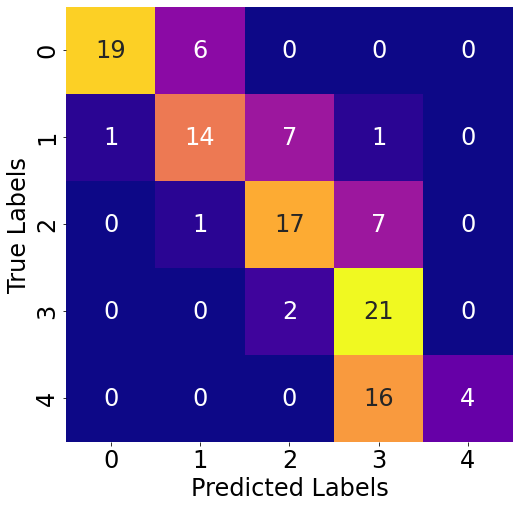

0.646551724137931

In [15]:
yy=y_test.argmax(1)
plt.figure(figsize = (8,8))
cm=confusion_matrix(yy, hat_test)

sns.heatmap(cm, annot = True, cbar=False, xticklabels = np.unique(yy), yticklabels = np.unique(yy), 
            cmap = 'plasma', annot_kws={'size':24})
plt.xlabel('Predicted Labels', size=24)
plt.ylabel('True Labels', size=24)
plt.xticks(size=24)
plt.yticks(size=24)
plt.show()
accuracy_score(yy, hat_test)